In [1]:
#import Libraries
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier



In [2]:
#import dataset
dataset = pd.read_csv('train.csv')

In [3]:
#Dimension of the data , a quick eye how the data are
#The MNIST set consists of 42,000 rows and 785 columns. 
#There are 28 x 28 pixel images of digits ( contributing to 784 columns) as well as one extra label column which is essentially a class label to state whether the row-wise contribution to each digit gives a 1 or a 9. 
#Each row component contains a value between one and zero and this describes the intensity of each pixel.

print(dataset.shape)



(42000, 785)


In [4]:
#Peak of the data
#head of data
#Looking at the raw data can reveal insights that you cannot get any other way. 
#It can also plant seeds that may later grow into ideas on how to better preprocess and handle the data
#As we can see the labels of each given pixel. The data seems to be OK , as we can observate every column has no missing
#data
dataset.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
##Since we are still having the problem that our dataset consists of a relatively large number of features (columns), we can reduce the dimensionality of the data. Before we start off, 
#let's conduct some cleaning of the train data by saving the label feature and then removing it from the dataframe


# save the labels to a Pandas series target
target = dataset['label']
# Drop the label feature
data = dataset.drop("label",axis=1)

In [6]:
##there is no need to Data Cleaning/Data Wrangling/Collect more data 

In [7]:
#Feature Selection

#Feature selection is a process where you automatically select those features in your data that contribute most to the prediction variable or output in which you are interested.
#Having irrelevant features in your data can decrease the accuracy of many models, especially linear algorithms like linear and logistic regression.
#Three benefits of performing feature selection before modeling your data are:
#Reduces Overfitting: Less redundant data means less opportunity to make decisions based on noise.
#Improves Accuracy: Less misleading data means modeling accuracy improves.
#Reduces Training Time: Less data means that algorithms train faster


#Since the original dimension is quite large, the dimensionality reduction becomes necessary.
#PCA is a linear transformation algorithm that seeks to project the original features of our data onto a smaller set of features ( or subspace ) while still retaining most of the information.
#As a pre-processing step either for further processing or visualisation we decompose raw data into their principal components using Principal Component Analysis (PCA). 
#This allows us to reduce the dimensionality of the data while retaining as much of their original variance as possible
##In a nutshell, PCA is a linear transformation algorithm that seeks to project the original features of our data onto a smaller set of features ( or subspace ) while still retaining most of the information. 


X = data.values


##PCA is effected by scale so you need to scale the features in the data before applying PCA. 
#You can transform the data onto unit scale (mean = 0 and variance = 1) 
#which is a requirement for the optimal performance of many machine learning algorithms. StandardScaler helps standardize the dataset’s features. 

scaler = StandardScaler().fit(X)
scaled_data = scaler.transform(X)

print (scaled_data.std())
print (scaled_data.mean())





/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.950295335404
7.39036032457e-19


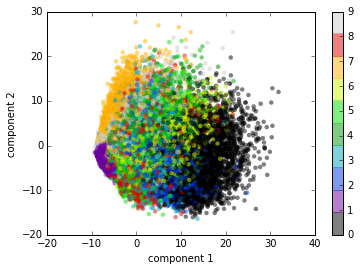

In [8]:
#pca with 2 components and scalled data
##where is my data ? ans:scatter-plot
sklearn_pca = PCA(n_components=2)
Y = sklearn_pca.fit_transform(scaled_data)



plt.scatter(Y[:, 0], Y[:, 1],
            c=target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()
plt.show()

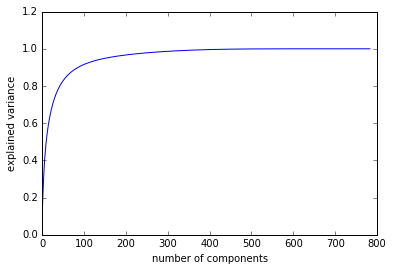

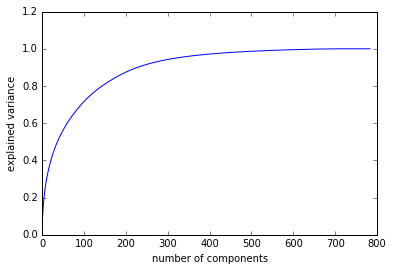

In [9]:
#We see that these 150 components account for just over 90% of the variance. That would lead us to believe that using these 150 components, 

pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.show()



##with scaled data 
pca = PCA().fit(scaled_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.show()


##as we see more components are needed with scaled data!


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.275238095238
0.416904761905
0.489404761905
0.624523809524
0.743333333333
0.92619047619
0.965119047619
0.973095238095
0.971666666667
0.968571428571
0.968214285714


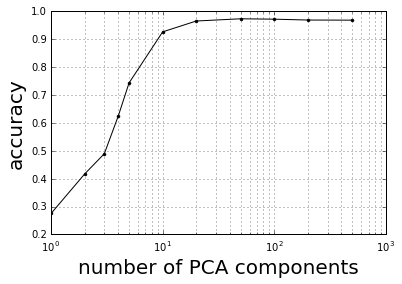

In [11]:
##calculating accuracies for pca
##The accuracy seems to saturate at ~90% (sroughly matching the performance of the random forest classifier) for >~20 PCA components. 
#In fact, the accuracy even seems to drop for much larger numbers, even though a larger number of PCA components captures more of the variance in the data, 
#as seen in the plot above. The drop in accuracy is probably due to overfitting.
from sklearn.metrics import accuracy_score

def evaluate_classifier(clf, data, target, split_ratio):
    trainX, testX, trainY, testY = train_test_split(data, target, train_size=split_ratio, random_state=0)
    clf.fit(trainX, trainY)
    #predict=clf.predict(testX)
    #print(accuracy_score(testY,predict))
    #print("-----------")
    return clf.score(testX,testY)

clf = KNeighborsClassifier()
n_components_array=([1,2,3,4,5,10,20,50,100,200,500])
score_array = np.zeros(len(n_components_array))
i=0

for n_components in n_components_array:
    pca = PCA(n_components=n_components)
    pca.fit(data)
    transform = pca.transform(data)
    score_array[i] = evaluate_classifier(clf, transform, target, 0.8)
    print(score_array[i])
    i=i+1

plt.plot(n_components_array,score_array,'k.-')
plt.xscale('log')
plt.xlabel("number of PCA components", size=20)
plt.ylabel("accuracy", size=20)
plt.grid(which="both")
plt.show()






In [ ]:
##PCA accuracy (best)


pca = PCA(n_components=120)
pca.fit(X)
transform = pca.transform(X)
print(evaluate_classifier(clf, transform, target, 0.8))


In [ ]:
##Apply a set of algorithms and select the best model
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))


In [ ]:
## smaller dataset , larget dataset causing kernel panic!!! 

small_data_train, small_data_test, small_target_train, small_target_test = train_test_split(transform,target, test_size=0.971415, random_state=42)

print (len(small_data_train))

validation_size = 0.20
seed = 7
scoring = 'accuracy'


results = []
names   = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, transform[0:1000], target[0:1000], cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

In [ ]:
#hyper parameters testing 

#With Hyper Parameters Tuning
#2-4,kNearestNeighbors
#importing modules
from sklearn.model_selection import GridSearchCV
#making the instance
model = KNeighborsClassifier(n_jobs=-1)
#Hyper Parameters Set
params = {'n_neighbors':[5,6,7,8,9,10],
          'leaf_size':[1,2,3,5],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute'],
          'n_jobs':[-1]}

#Making models with hyper parameters sets
model1 = GridSearchCV(model, param_grid=params, n_jobs=1)
#Learning
model1.fit(small_data_train,small_target_train)
#The best hyper parameters set
print("Best Hyper Parameters:\n",model1.best_params_)
#Prediction
prediction=model1.predict(small_data_test)
#importing the metrics module
from sklearn import metrics
#evaluation(Accuracy)
print("Accuracy:",metrics.accuracy_score(prediction,small_target_test))



In [ ]:
#Building multiple models (typically of differing types) and simple statistics (like calculating the mean) are used to combine predictions.
#It works by first creating two or more standalone models from your training dataset. A Voting Classifier can then be used to wrap your models and average the predictions 
#of the sub-models when asked to make predictions for new data.






estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = DecisionTreeClassifier()
estimators.append(('cart', model2))
model3 = SVC()
estimators.append(('svm', model3))

kfold = KFold(n_splits=10, random_state=7)


ensemble = VotingClassifier(estimators)
results = cross_val_score(ensemble, transform[0:1000], target[0:1000], cv=kfold)
print(results.mean())

In [ ]:
from sklearn.ensemble import AdaBoostClassifier


#AdaBoostworks by weighting instances in the dataset by how easy or difficult they are to classify, 
#allowing the algorithm to pay or or less attention to them in the construction of subsequent models.
#Boosting ensemble algorithms creates a sequence of models that attempt to correct the mistakes of the models before them in the sequence.
#Once created, the models make predictions which may be weighted by their demonstrated accuracy
#and the results are combined to create a final output prediction.

pca = PCA(n_components=120)
pca.fit(data)
transform = pca.transform(data)

seed = 7
num_trees = 30
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = AdaBoostClassifier(n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, transform, target, cv=kfold)
print(results.mean())

In [ ]:

#Random forest is an extension of bagged decision trees.
#Samples of the training dataset are taken with replacement, but the trees are constructed in a way that reduces the correlation between individual classifiers. Specifically, rather than greedily choosing the best split point in the construction of the tree, only a random subset of features are considered for each split.



print('Loading training data')

scores = list()
scores_std = list()

print('Start learning...')
n_trees = [10, 15, 20, 25, 30, 40, 50, 70, 100, 150]
for n_tree in n_trees:
    print(n_tree)
    recognizer = RandomForestClassifier(n_tree)
    score = cross_val_score(recognizer, data, target)
    scores.append(np.mean(score))
    scores_std.append(np.std(score))

sc_array = np.array(scores)
std_array = np.array(scores_std)

plt.plot(n_trees, scores)
plt.ylabel('score')
plt.xlabel('# of trees')

plt.show()